In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import sys
from itertools import chain

import numpy as np

from bounding_box_classifiers.obama_detector import train_helper, BasicConvNet

In [3]:
data_dir = "data/bounding-box-obama-detector"

static_params = {
    "seed": 1,
    "data_dir": data_dir,
    "use_cuda": True,
    "val_batch_size": 64,
    "epochs": 20,
    "log_interval": 10
}

variable_params = {
    "lr": [0.1, 0.01, 0.001, 0.001],
    "momentum": [0.5, 0.6, 0.7, 0.8, 0.9],
    "batch_size": [32, 64, 128]
}

In [ ]:
# Run random search
used_variable_params = set()
param_space_size = np.prod([len(p) for p in variable_params])
while len(used_variable_params) < param_space_size:
    curr_params = {k: random.choice(v) for k, v in variable_params.items()}
    curr_variable_params = tuple(chain.from_iterable(curr_params.items()))

    if curr_variable_params not in used_variable_params:
        print("Current variable parameters:", curr_variable_params)
        used_variable_params.add(curr_variable_params)
        curr_params.update(static_params)
        train_helper(**curr_params)

# Best results
Both with 62% test accuracy:
```
('--lr', '0.001', '--momentum', '0.9', '--batch-size', '32')  # epoch 2
('--lr', '0.01', '--momentum', '0.6', '--batch-size', '32')  # epoch 5
```

In [9]:
# Reproduce best results
best_params = {
    "lr": 0.01,
    "momentum": 0.6,
    "batch_size": 32
}
best_params.update(static_params)
best_model_state_dict = train_helper(**best_params)

Train Epoch: 1 [0/248 (0%)]	Loss: 0.767255

Test set: Average loss: 4.1698, Accuracy: 33/64 (52%)

Train Epoch: 2 [0/248 (0%)]	Loss: 4.871858

Test set: Average loss: 2.7593, Accuracy: 30/64 (47%)

Train Epoch: 3 [0/248 (0%)]	Loss: 2.008294

Test set: Average loss: 1.5813, Accuracy: 35/64 (55%)

Train Epoch: 4 [0/248 (0%)]	Loss: 1.556309

Test set: Average loss: 1.0493, Accuracy: 36/64 (56%)

Train Epoch: 5 [0/248 (0%)]	Loss: 1.022617

Test set: Average loss: 0.9921, Accuracy: 39/64 (61%)

Train Epoch: 6 [0/248 (0%)]	Loss: 0.648816

Test set: Average loss: 1.1247, Accuracy: 30/64 (47%)

Train Epoch: 7 [0/248 (0%)]	Loss: 0.827706

Test set: Average loss: 0.9251, Accuracy: 35/64 (55%)

Train Epoch: 8 [0/248 (0%)]	Loss: 1.146976

Test set: Average loss: 0.7572, Accuracy: 40/64 (62%)

Train Epoch: 9 [0/248 (0%)]	Loss: 0.811453

Test set: Average loss: 0.7837, Accuracy: 33/64 (52%)

Train Epoch: 10 [0/248 (0%)]	Loss: 0.895659

Test set: Average loss: 0.8217, Accuracy: 32/64 (50%)

Train Epo

# Create visualizations

In [11]:
import sys
sys.path.append('pytorch_cnn_visualizations')

import torch
from PIL import Image

from bounding_box_classifiers.obama_detector import data_loaders
from pytorch_cnn_visualizations.vanilla_backprop import VanillaBackprop
from pytorch_cnn_visualizations.guided_backprop import GuidedBackprop
from pytorch_cnn_visualizations.misc_functions import preprocess_image, format_np_output

In [12]:
def show_gradient_images(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    
    # Show PIL image
    return Image.fromarray(format_np_output(gradient))

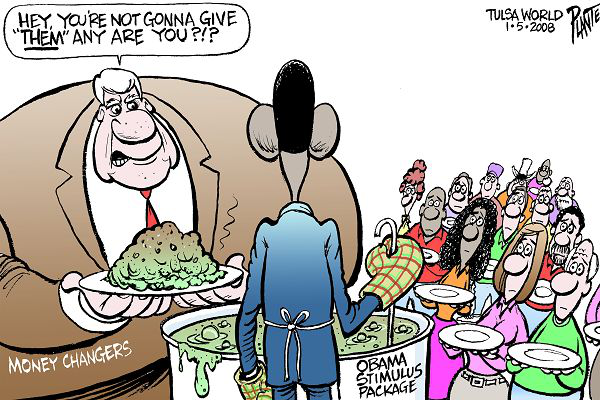

In [43]:
device = torch.device("cuda")

# Load data
train_loader, test_loader = data_loaders(data_dir, use_cuda=True, 
                                         batch_size=1, val_batch_size=1)

# Find an image of Obama
dataset = test_loader.dataset
examples = [(i, dataset[i]) for i in range(len(dataset)) if dataset[i][1] == 1]

example_num = 23
example_x, example_y = examples[example_num][1]
original_example_num = examples[example_num][0]

example_x = example_x.unsqueeze(dim=0)
example_x = example_x.to(device)
example_x.requires_grad_()

# Display_image
original_x = test_loader.dataset.samples[original_example_num][0]
im = Image.open(original_x).convert('RGB')
im

In [44]:
# Load best model weights
best_model = BasicConvNet()
best_model.load_state_dict(best_model_state_dict)
best_model.to(device)

BasicConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=107648, out_features=2, bias=True)
)

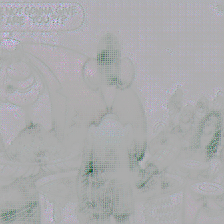

In [45]:
# Guided backprop
GBP = GuidedBackprop(best_model)

# Generate gradients
guided_grads = GBP.generate_gradients(example_x, example_y)
show_gradient_images(guided_grads)

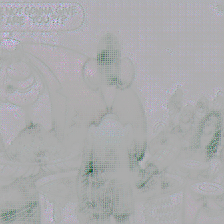

In [47]:
# Vanilla backprop
VBP = VanillaBackprop(best_model)

# Generate gradients
vanilla_grads = VBP.generate_gradients(example_x, example_y)
show_gradient_images(vanilla_grads)